# SD701 Data Mining
Par Pierre Dal Bianco et Nicolas Esdras

In [1]:
# we do our imports
import sklearn as sk
import numpy as np
from sklearn import cluster
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

## Partie 1 : exploration du dataset
Le jeu de données provient du site Kaggle : https://www.kaggle.com/tiagotgoz/predictive-useful-life-based-into-telemetry

Il contient 24h de cycle sur 100 machines avec des données de capteurs et des d'autres données sur l'état des machines. La liste exhaustive des colonnes est la suivante :
- machineID : ID de la machine
- datetime : Date de télémétrie
- timeincycles : Lecture de cycle
- voltmean24h : Moyenne télémétrique en volt des dernières 24h
- rotatemean24h : Moyenne télémétrique en rotation des dernières 24h
- pressuremean24h : Moyenne de télémétrie de pression des dernières 24h
- vibrationmean24h : Moyenne de télémétrie de vibration des dernières 24h
- voltsd24h : Écart-type de télémétrie Volt des dernières 24h
- rotatesd24h : Rotation de l'écart-type de télémétrie des dernières 24h
- pressuresd24h : Écart-type de télémétrie de pression des dernières 24h
- vibrationsd24h : Écart-type de télémétrie de vibration des dernières 24h
- voltmean5d : Moyenne télémétrique en volt des 5 derniers jours
- rotatemean5d : Faire pivoter la moyenne télémétrique des 5 derniers jours
- pressuremean5d : Moyenne de télémétrie de pression des 5 derniers jours
- vibrationmean5d : Moyenne de télémétrie de vibration des 5 derniers jours
- voltsd5d : Écart type de télémétrie Volt des 5 derniers jours
- rotatesd5d : Rotation de l'écart type de télémétrie des 5 derniers jours
- Pressuresd5d : Écart-type de télémétrie de pression des 5 derniers jours
- vibrationsd5d : Écart-type de télémétrie de vibration des 5 derniers jours
- error1 : Identification de l'erreur 1
- error2 : Identification de l'erreur 2
- error3 : Identification de l'erreur 3
- error4 : Identification de l'erreur 4
- error5 : Identification de l'erreur 5
- comp1 : Cycle de maintenance du composant 1
- comp2 : Cycle de maintenance du composant 2
- comp3 : Cycle de maintenance du composant 3
- comp4 : Cycle de maintenance du composant 4
- model : Modèle de machine
- age : Âge de la machine
- RUWeek : Temps en semaines pour l'échec
- failure : Identification du composant qui a échoué
- failed : Échec ou non
- RUL : Durée de vie utile restante en cycles par panne et machine
- RUL_I : RUL inverse 

In [2]:
# we read the csv file
data = pd.read_csv("ALLtrainMescla5D.csv.zip")

# we convert the failure variable into a number which represents the type of failure with 0 = no failure
data['failure'] = data['failure'].map({'none':0, 'comp1':1,  'comp2':2,  'comp3':3,  'comp4':4})

# we convert the datetime column into a datetime data type
data['datetime'] = data['datetime'].apply(lambda d: datetime.datetime.strptime(d, '%Y-%m-%d'))
data = data.sort_values('datetime', ignore_index=True)
data.head()

,machineID,datetime,time_in_cycles,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,...,comp3,comp4,model,age,DI,RULWeek,failure,failed,RUL,RUL_I
0,2,2015-01-05,1,170.983586,458.211435,102.630291,41.655238,16.170897,48.399526,10.206313,...,0.0,0.0,model4,7,2.673599,1.0,0,0,1.0,73.0
1,78,2015-01-05,1,171.244562,443.428047,101.368139,40.974623,14.591701,55.864090,10.820901,...,0.0,0.0,model4,19,0.000000,1.0,0,0,1.0,31.0
2,55,2015-01-05,1,171.563096,451.281569,100.017165,39.139113,13.238429,61.624450,9.798919,...,0.0,0.0,model3,17,2.653564,1.0,0,0,1.0,61.0
3,80,2015-01-05,1,166.681888,470.366849,97.964395,38.602278,15.099637,52.184320,7.630042,...,0.0,0.0,model3,6,2.686396,1.0,0,0,1.0,188.0
4,34,2015-01-05,1,171.702752,437.086634,120.063679,40.315629,10.279047,47.538413,13.112419,...,0.0,0.0,model4,10,2.692270,1.0,0,0,1.0,101.0


Est-ce que nous avons les types de données attendues ?

In [3]:
# let's check the types
data.dtypes

machineID                     int64
datetime             datetime64[ns]
time_in_cycles                int64
voltmean_24h                float64
rotatemean_24h              float64
pressuremean_24h            float64
vibrationmean_24h           float64
voltsd_24h                  float64
rotatesd_24h                float64
pressuresd_24h              float64
vibrationsd_24h             float64
voltmean_5d                 float64
rotatemean_5d               float64
pressuremean_5d             float64
vibrationmean_5d            float64
voltsd_5d                   float64
rotatesd_5d                 float64
pressuresd_5d               float64
vibrationsd_5d              float64
error1                      float64
error2                      float64
error3                      float64
error4                      float64
error5                      float64
comp1                       float64
comp2                       float64
comp3                       float64
comp4                       

Combien de machines différentes est-ce que nous avons ?

In [4]:
print('{} valeurs uniques entre {} et {}'.format(data['machineID'].nunique(), data['machineID'].min(), data['machineID'].max()))

98 valeurs uniques entre 1 et 100


Il semble qu'il y ait deux ID inexistants puisqu'on a 98 valeurs entre 1 et 100, essayons de les identifier

In [5]:
# this returns the elements missing, we are hoping to find none
print('Les deux valeurs manquantes sont {}'.format(set(range(1, 100)) - set(data['machineID'].unique())))

Les deux valeurs manquantes sont {77, 6}


Quel est l'age moyen de chaque machine ?

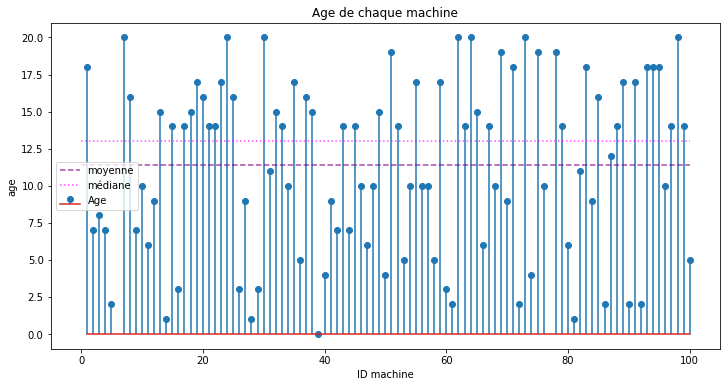

In [6]:
plt.figure(figsize=(12,6))
machines_age = data.groupby('machineID')['age'].mean()
plt.stem(machines_age.index, machines_age, label='Age');
plt.hlines(machines_age.mean(), xmin=0, xmax=100, linestyle='dashed', color='purple', alpha=0.7, label='moyenne')
plt.hlines(machines_age.median(), xmin=0, xmax=100, linestyle = 'dotted', color='magenta', alpha=0.7, label='médiane')
plt.xlabel('ID machine')
plt.ylabel('age')
plt.title('Age de chaque machine');
plt.legend();

Les mesures ont été réalisées sur quelle période de temps ?

In [7]:
print('Première mesure : {}'.format(data['datetime'].min()))
print('Durée totale des mesures : {}'.format((data['datetime'].max() - data['datetime'].min())))

Première mesure : 2015-01-05 00:00:00
Durée totale des mesures : 360 days 00:00:00


Y-a-t-il des dates manquantes dans les mesures ?

In [8]:
# this returns the elements missing, we are hoping to find none
pd.date_range(start = data['datetime'].min(), end = data['datetime'].max(), freq='d').difference(data['datetime'])

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

Y-a-t-il des duplicats ?

In [9]:
data.duplicated().any()

False

Y-a-t-il des valeurs nulles / na ?

In [10]:
data.isna().any().any()

False

Affichons quelques graphes sur les données de mesures ```voltsd_24h```, ```rotatesd_24h```, ```pressuresd_24h```, et ```vibrationsd_24h``` sur 4 machines tirées aléatoirement pour voir à quoi cela ressemble

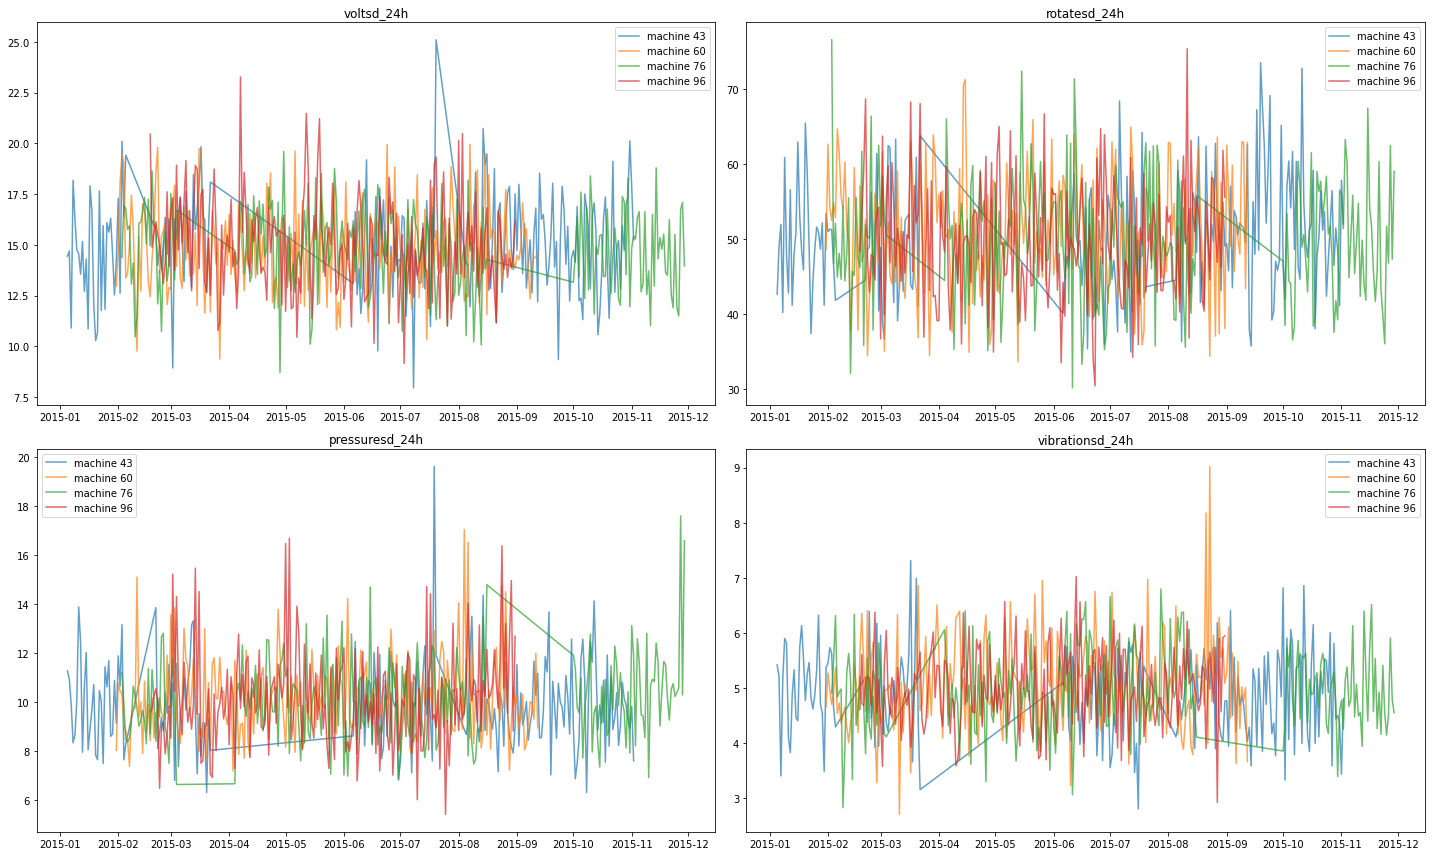

In [11]:
# we prepare our plot
fig = plt.figure(figsize=(20, 12));
k = 1

machineID = np.random.choice(data['machineID'].unique(), 4)
columns_graph = ['voltsd_24h', 'rotatesd_24h', 'pressuresd_24h', 'vibrationsd_24h']

# for each column
for col in columns_graph:
    # we add a subplot
    ax = fig.add_subplot(2, 2, k)
    # we plot the categories in each subplot
    for id in machineID:
        ax.plot(data.loc[data['machineID'] == id, 'datetime'],
                data.loc[data['machineID'] == id, col],
                label = 'machine ' + str(id), alpha=0.7);
        ax.set_title(col);
    #ax.autoscale(axis='x',tight=True);
    ax.legend();
    k+=1
fig.tight_layout()

Il semble y avoir des données lissées sur plusieurs jours, nous allons voir si cela a un impacte sur nos prédictions. Essayons de voir l'évolution des différentes grandeurs numériques au cours du temps. Nous allons rajouter le nombre de pannes en arrière plan de chaque graphique.

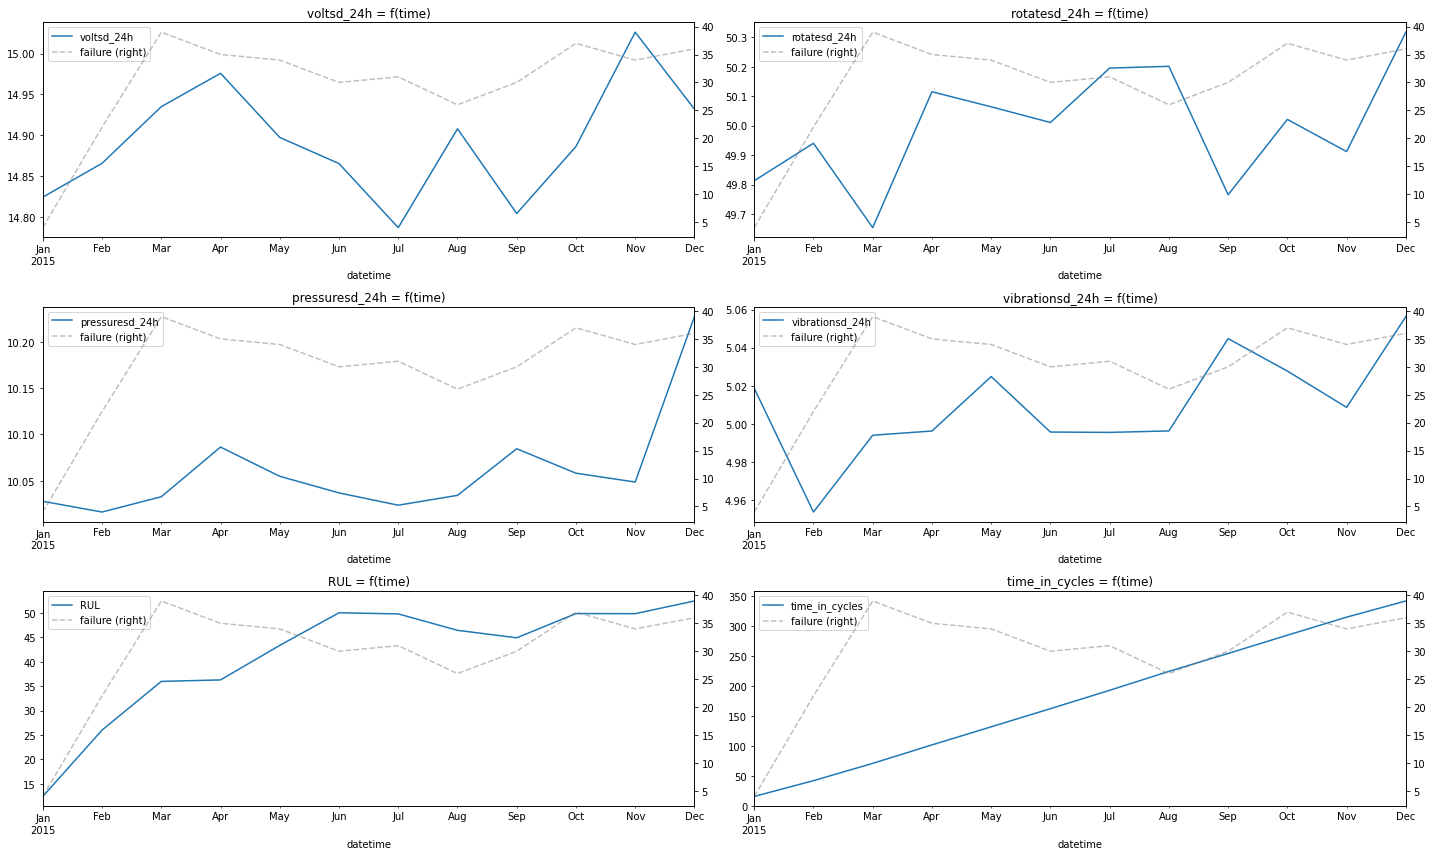

In [12]:
columns_graph = ['voltsd_24h', 'rotatesd_24h', 'pressuresd_24h', 'vibrationsd_24h', 'RUL', 'time_in_cycles']
data_resampled = data.resample(rule='M', on='datetime').mean()[columns_graph].interpolate(method='linear')
data_failure_resampled = data[data['failure'] > 0].resample(rule='M', on='datetime').count()['failure'].interpolate(method='linear')

# we prepare our plot
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 12))

k=0
# we plot the column data in each subplot
for i in range(3):
    for j in range(2):
        data_resampled[columns_graph[k]].plot(ax=axes[i,j], legend=columns_graph[k]);
        data_failure_resampled.plot(secondary_y=True, ax=axes[i,j], legend='failures', alpha=0.5, linestyle='dashed', color='gray');
        axes[i,j].set_title(columns_graph[k]+' = f(time)')
        k+=1
fig.tight_layout();

Essayons de visuliser les fonctions de densités des grandeurs numériques. 

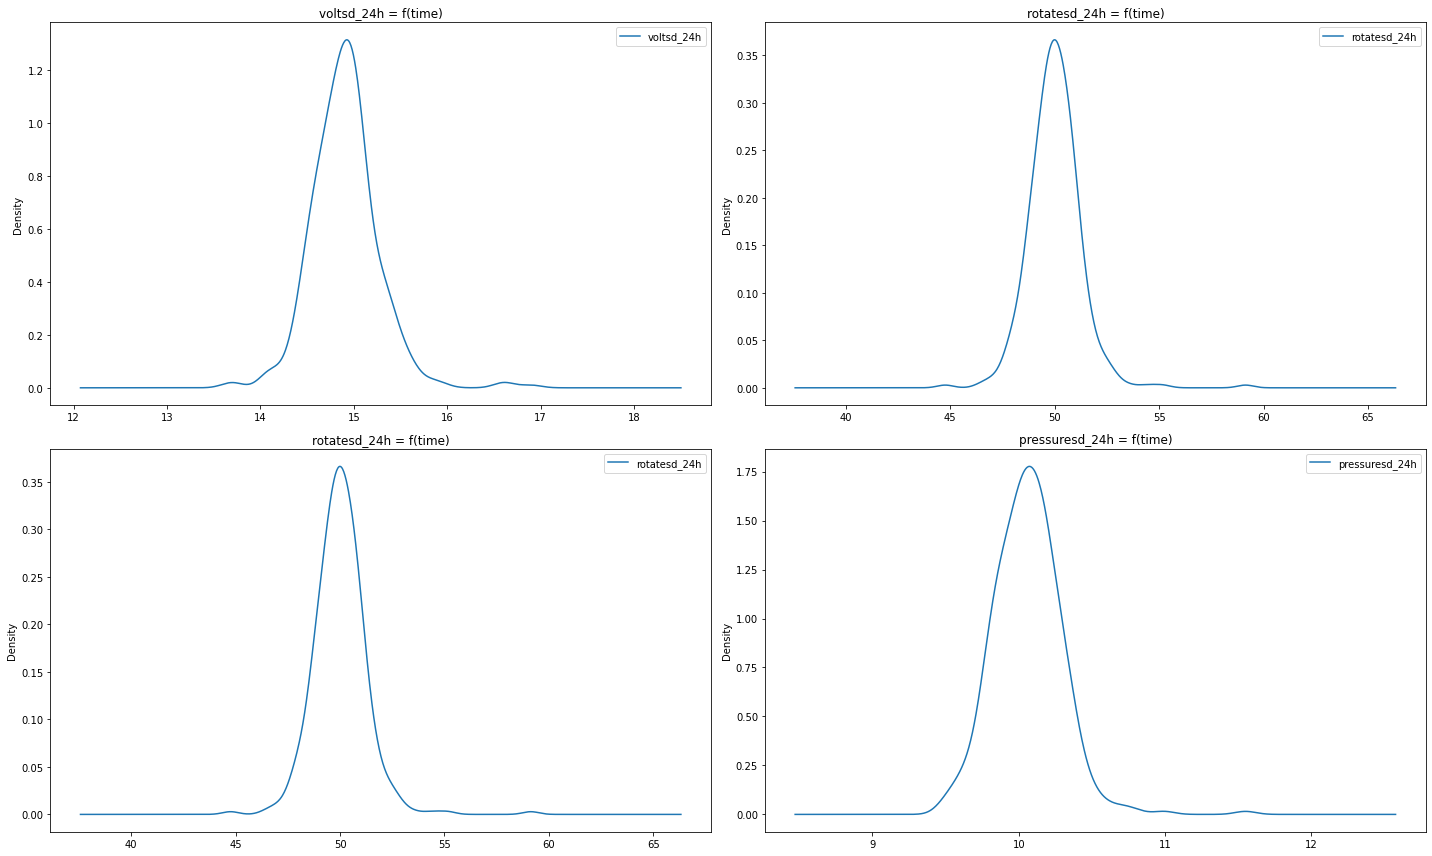

In [13]:
# https://pandas.pydata.org/pandas-docs/version/0.13.1/visualization.html#targeting-different-subplots

columns_graph = ['voltsd_24h', 'rotatesd_24h', 'pressuresd_24h', 'vibrationsd_24h']
data_resampled = data.resample(rule='D', on='datetime').mean()[columns_graph].interpolate(method='linear')
# we prepare our plot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))

# we plot the column data in each subplot
for i in range(2):
    for j in range(2):
        data_resampled[columns_graph[i+j]].plot(kind='kde', ax=axes[i,j], legend=columns_graph[i+j]);
        axes[i,j].set_title(columns_graph[i+j]+' = f(time)')

fig.tight_layout();

On peut aussi tracer un histogramme du nombre de panne par type de panne, pour voir s'il y a un type qui apparaît plus souvent. Nous allons tracer la même chose avec le nombre d'erreurs.

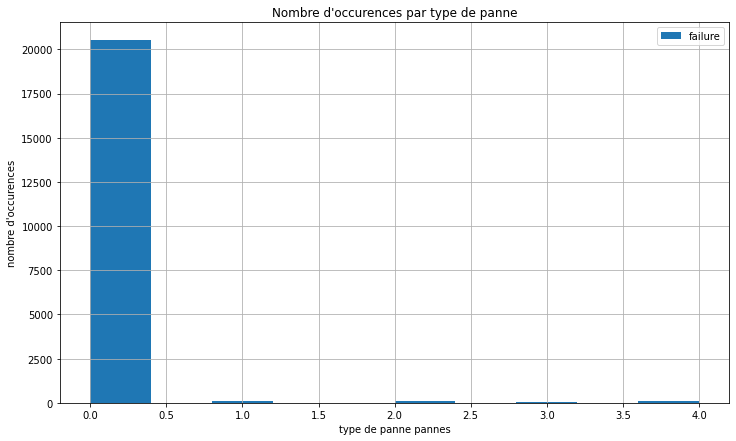

In [14]:
# we prepare our plot
data['failure'].hist(figsize=(12, 7), legend='failure');
plt.xlabel('type de panne pannes')
plt.ylabel('nombre d\'occurences')
plt.title('Nombre d\'occurences par type de panne')
plt.legend();

On constate déjà une grosse disparité entre les classes et notammenent la classe 0 qui correspond au non-échec (ie fonctionnement normal). Il faudrait donc s'orienter vers des algorithmes capable de gérer ces grosses disparités. En complément, on pourra essayer de regrouper tous les échecs dans une même catégorie dans un premier temps afin d'augmenter l'effectif de la classe pour faire classification en deux temps : échec? (True ou False) puis quel type d'échec si failure=True.

On constate cependant qu'il semble y avoir un lien entre le nombre d'erreurs et le nombre de pannes.

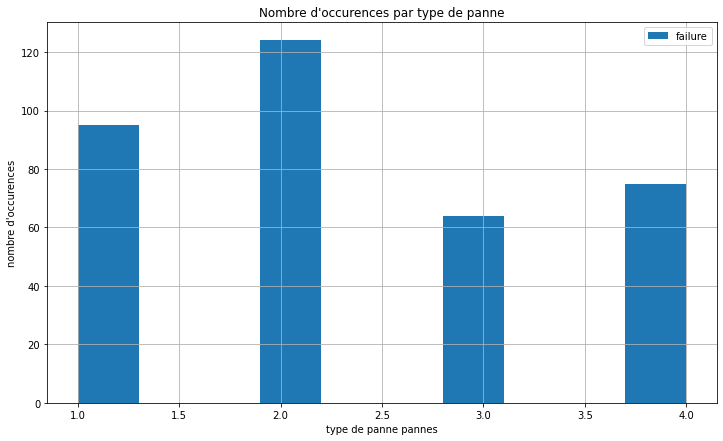

In [15]:
data['failure'][data['failure'] > 0].hist(figsize=(12, 7), legend='failure');
plt.xlabel('type de panne pannes')
plt.ylabel('nombre d\'occurences')
plt.title('Nombre d\'occurences par type de panne');

Affichons un histogramme du nombre d'erreurs simultanées

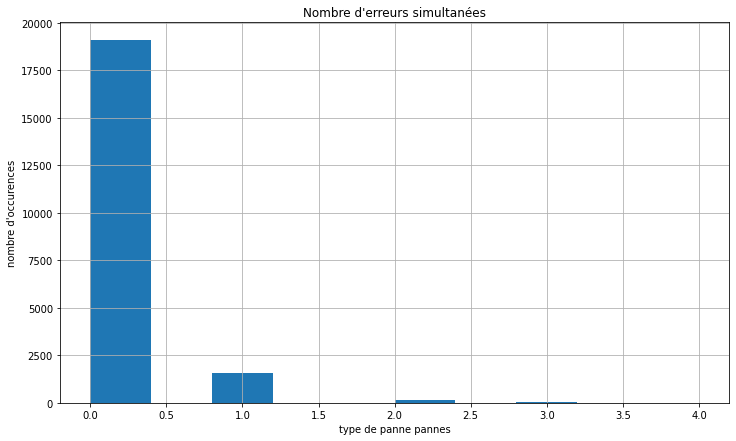

In [16]:
# we prepare our plot
(data['error1']+data['error2']+data['error3']+data['error4']).hist(figsize=(12, 7));
plt.xlabel('type de panne pannes');
plt.ylabel('nombre d\'occurences');
plt.title('Nombre d\'erreurs simultanées');

Le type d'échec une fois la classe 0 (pas d'échec) retirée : les classes échec sont réparties à peu près uniformément à première vue.

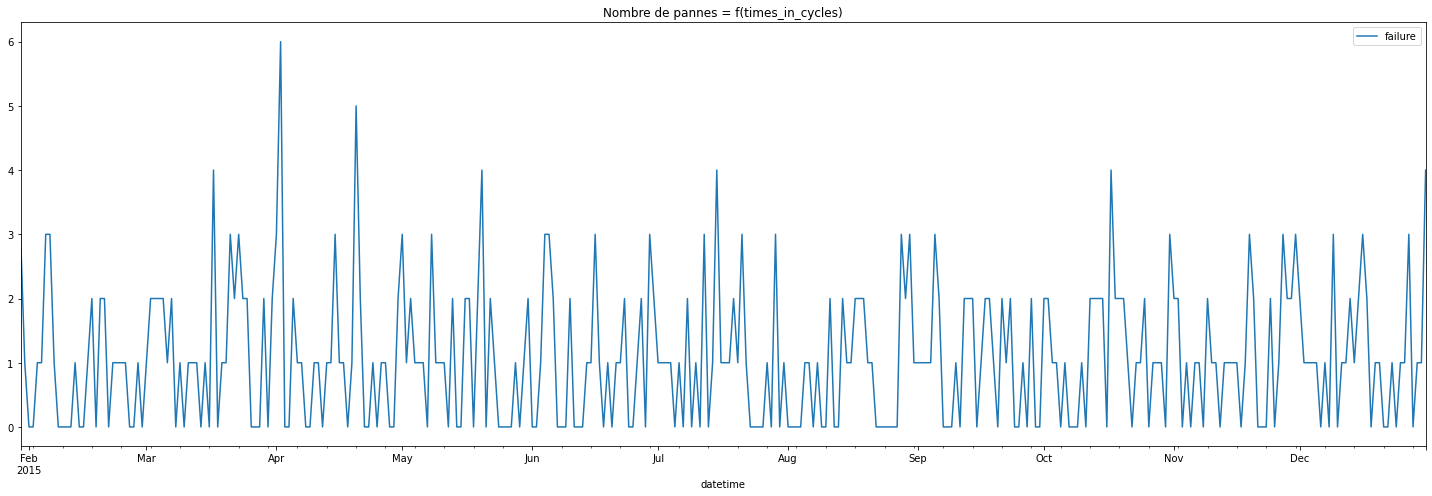

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 7))
data[data['failure'] > 0].resample(rule='D', on='datetime').count()['failure'].interpolate(method='linear').plot(legend='failures', ax=ax);
#ax.set_xticks(np.arange(0, 360, 10));
ax.set_title('Number of failures = f(time)');
ax.legend()
ax.set_title('Nombre de pannes = f(times_in_cycles)');
fig.tight_layout()

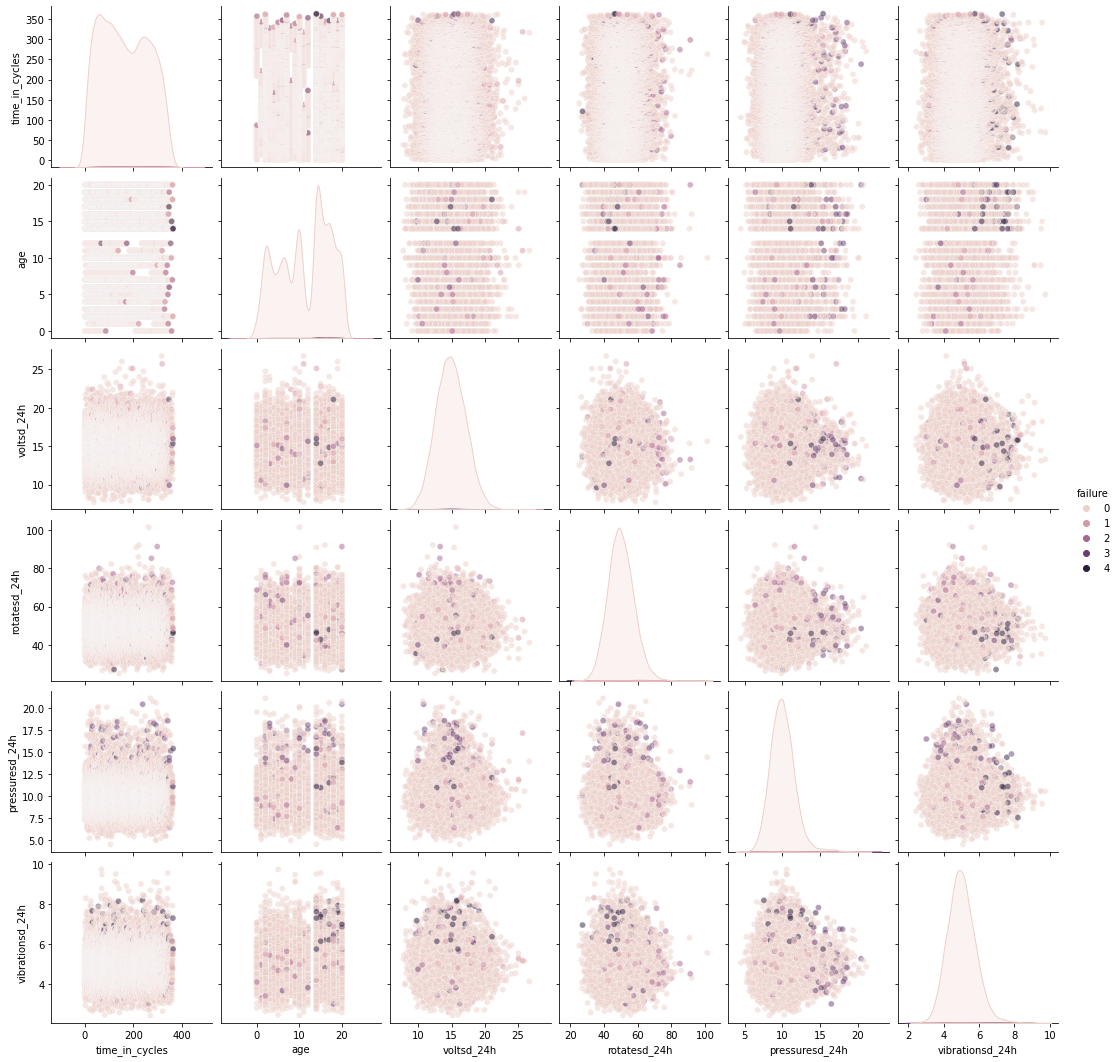

In [18]:
num_columns = ['time_in_cycles', 'age',
               'voltsd_24h', 'rotatesd_24h', 'pressuresd_24h', 'vibrationsd_24h',
               'failure']
sns.pairplot(data[num_columns], hue='failure', plot_kws={'alpha':0.5});